In [3]:
df= pd.read_csv(r"C:\Users\hp\Downloads\archive (1)\credit_card_transaction_flow.csv")

In [45]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import networkx as nx
import shap 
import warnings

warnings.filterwarnings('ignore')

In [4]:
df.head()

,Customer ID,Name,Surname,Gender,Birthdate,Transaction Amount,Date,Merchant Name,Category
0,752858,Sean,Rodriguez,F,20-10-2002,$35.47,03-04-2023,Smith-Russell,Cosmetic
1,26381,Michelle,Phelps,NaN,24-10-1985,"$2,552.72",17-07-2023,"Peck, Spence and Young",Travel
2,305449,Jacob,Williams,M,25-10-1981,$115.97,20-09-2023,Steele Inc,Clothing
3,988259,Nathan,Snyder,M,26-10-1977,$11.31,11-01-2023,"Wilson, Wilson and Russell",Cosmetic
4,764762,Crystal,Knapp,F,02-11-1951,$62.21,13-06-2023,Palmer-Hinton,Electronics


In [6]:
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]
print(df.columns)


Index(['customer_id', 'name', 'surname', 'gender', 'birthdate',
       'transaction_amount', 'date', 'merchant_name', 'category'],
      dtype='object')


In [8]:
df['transaction_amount'] = (
    df['transaction_amount']
    .replace('[\$,]', '', regex=True)
    .astype(float)
)


In [11]:
for col in ['gender', 'category', 'merchant_name']:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna('Unknown')


In [12]:
# Transaction ID
df['transaction_id'] = range(1, len(df) + 1)

# Merchant ID: convert merchant names to numerical codes + 1 (so starts from 1)
df['merchant_id'] = df['merchant_name'].astype('category').cat.codes + 1

# Customer ID: ensure it's integer and unique if not already
df['customer_id'] = df['customer_id'].astype('category').cat.codes + 1


In [13]:
df['currency'] = 'USD'
df['transaction_type'] = 'Purchase'


In [15]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)


In [16]:
df.info

<bound method DataFrame.info of        customer_id       name    surname   gender   birthdate  \
0            37671       Sean  Rodriguez        F  20-10-2002   
1             1280   Michelle     Phelps  Unknown  24-10-1985   
2            15248      Jacob   Williams        M  25-10-1981   
3            49440     Nathan     Snyder        M  26-10-1977   
4            38252    Crystal      Knapp        F  02-11-1951   
...            ...        ...        ...      ...         ...   
49995        44619  Christine      Leach        F  21-10-1997   
49996        40026       Anna      Allen        F  21-10-1999   
49997         6646     Nicole   Franklin        M  26-10-1979   
49998        30812      Maria     Keller        M  25-10-1981   
49999        41609      Billy     Walker        F  31-10-1958   

       transaction_amount       date                 merchant_name  \
0                   35.47 2023-04-03                 Smith-Russell   
1                 2552.72 2023-07-17        Pec

         customer_id     name surname gender   birthdate  transaction_amount  \
count   50000.000000    50000   50000  50000       50000        50000.000000   
unique           NaN      690    1000      3          58                 NaN   
top              NaN  Michael   Smith      F  01-11-1954                 NaN   
freq             NaN     1167    1095  22713         914                 NaN   
mean    25000.500000      NaN     NaN    NaN         NaN          442.119239   
min         1.000000      NaN     NaN    NaN         NaN            5.010000   
25%     12500.750000      NaN     NaN    NaN         NaN           79.007500   
50%     25000.500000      NaN     NaN    NaN         NaN          182.195000   
75%     37500.250000      NaN     NaN    NaN         NaN          470.515000   
max     50000.000000      NaN     NaN    NaN         NaN         2999.880000   
std     14433.901067      NaN     NaN    NaN         NaN          631.669724   

                                 date m

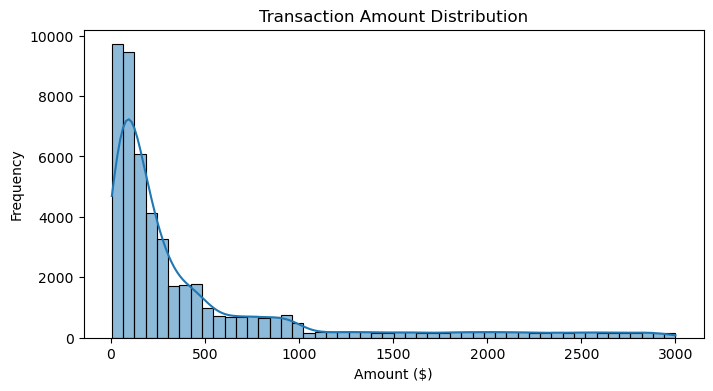

In [21]:
print(df.describe(include='all'))

# Transaction amount distribution
plt.figure(figsize=(8,4))
sns.histplot(df['transaction_amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount ($)')
plt.ylabel('Frequency')
plt.show()


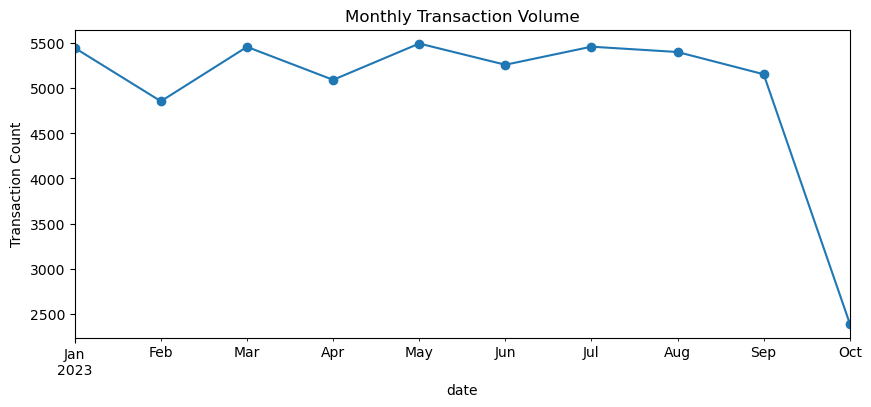

In [64]:
# Transactions per month
df.set_index('date').resample('M')['transaction_id'].count().plot(marker='o', figsize=(10,4))
plt.title("Monthly Transaction Volume")
plt.ylabel("Transaction Count")
plt.show()


In [23]:
# Top merchants by transaction volume
top_merchants = df['merchant_name'].value_counts().head(10)
print(top_merchants)

# Revenue by category
category_rev = df.groupby('category')['transaction_amount'].sum().sort_values(ascending=False)
print(category_rev)


merchant_name
Smith Ltd         69
Smith Group       65
Smith PLC         65
Smith Inc         60
Smith LLC         60
Smith and Sons    56
Johnson PLC       55
Williams LLC      54
Johnson LLC       53
Johnson Ltd       50
Name: count, dtype: int64
category
Travel         12900231.94
Electronics     4394092.10
Market          2151134.42
Clothing        1319342.47
Cosmetic         876672.44
Restaurant       464488.60
Name: transaction_amount, dtype: float64


In [24]:
# Average and count per customer for modeling
df['customer_avg_amt'] = df.groupby('customer_id')['transaction_amount'].transform('mean')
df['customer_txn_count'] = df.groupby('customer_id')['transaction_id'].transform('count')


In [25]:
# Number of unique customers per merchant
df['merchant_customer_count'] = df.groupby('merchant_id')['customer_id'].transform('nunique')


In [28]:
# Flag: is this customer's first transaction with this merchant?
def customer_first_merchant(row):
    hist = df[(df['customer_id'] == row['customer_id']) & (df['merchant_id'] == row['merchant_id'])]
    return 1 if hist.index.min() == row.name else 0

df['first_time_merchant'] = df.apply(customer_first_merchant, axis=1)


In [29]:
model_cols = [
    'transaction_amount',
    'customer_avg_amt',
    'customer_txn_count',
    'merchant_customer_count',
    'first_time_merchant'
]

X = df[model_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [30]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df['anomaly_flag'] = iso_forest.fit_predict(X_scaled)
df['anomaly_flag'] = df['anomaly_flag'].apply(lambda x: 1 if x == -1 else 0)


In [31]:
def anomaly_narrative(row):
    messages = []
    if row['transaction_amount'] > row['customer_avg_amt'] * 3:
        messages.append("Unusually high for this customer.")
    if row['first_time_merchant'] == 1:
        messages.append("First time at this merchant.")
    if row['merchant_customer_count'] < 5:
        messages.append("Merchant rarely used by others.")
    return " | ".join(messages) if messages else "Routine"

df['anomaly_reason'] = df.apply(lambda x: anomaly_narrative(x) if x['anomaly_flag'] else 'None', axis=1)


In [32]:
# Potential loss estimation
df['potential_loss'] = np.where(df['anomaly_flag'] == 1, df['transaction_amount'], 0)
total_loss_avoided = df['potential_loss'].sum()
print(f"Estimated fraud loss avoided: ${total_loss_avoided:,.2f}")


Estimated fraud loss avoided: $847,478.88


In [33]:
# Placeholder column for human-in-the-loop label
df['analyst_label'] = None  # 'Fraud', 'Legit', or 'Unreviewed'


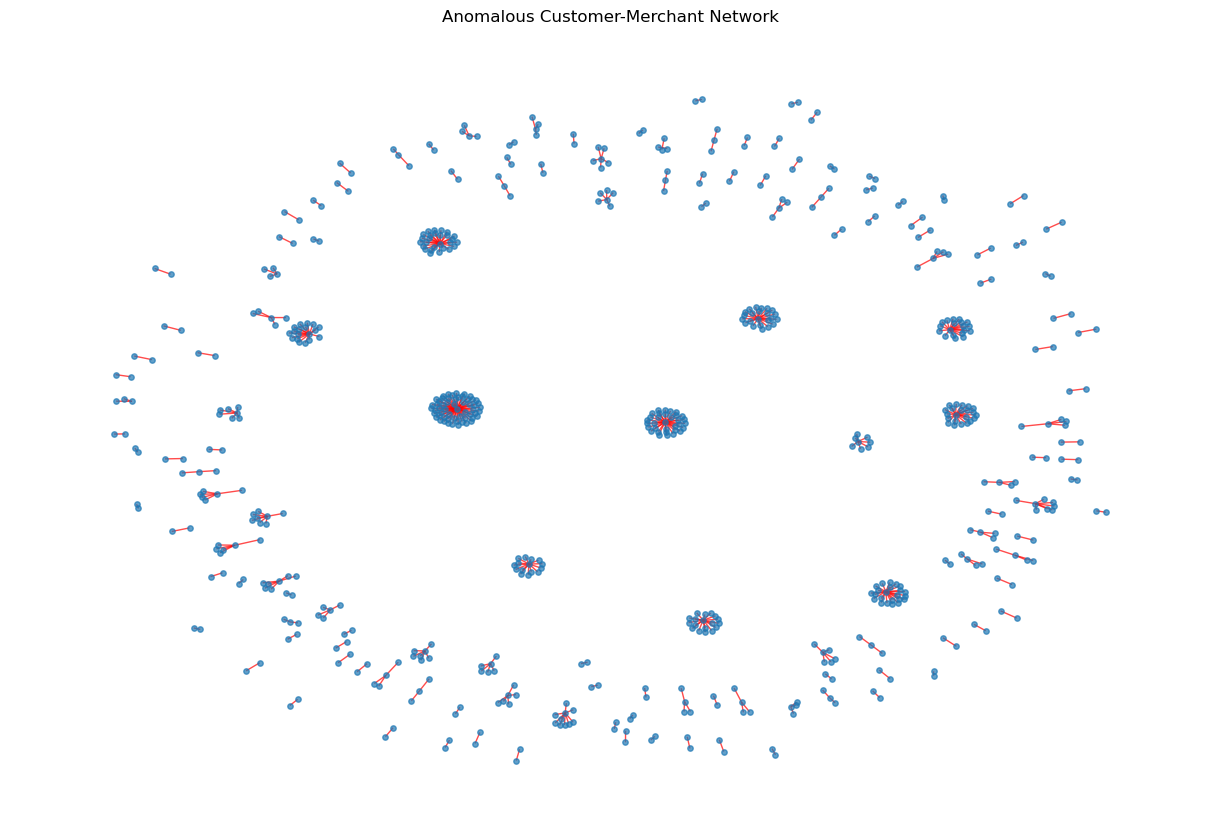

In [34]:
# Create a customer-merchant interaction graph for flagged anomalies
G = nx.Graph()
for _, row in df[df['anomaly_flag'] == 1].iterrows():
    G.add_edge(f"Customer_{row['customer_id']}", f"Merchant_{row['merchant_id']}")

plt.figure(figsize=(12,8))
nx.draw(G, node_size=15, alpha=0.7, edge_color='r')
plt.title("Anomalous Customer-Merchant Network")
plt.show()


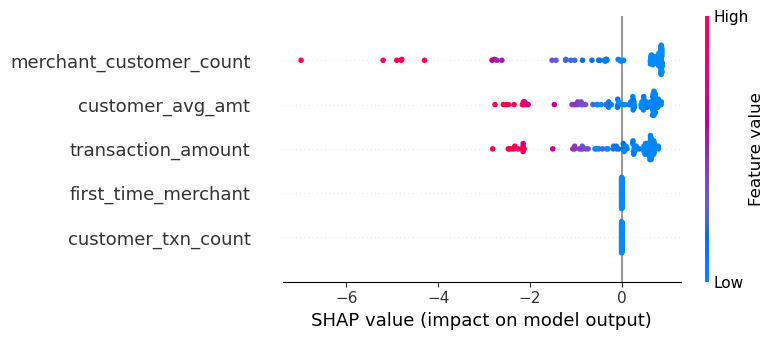

In [46]:
explainer = shap.TreeExplainer(iso_forest)
shap_values = explainer.shap_values(X_scaled[:100])  # Use a sample for speed
shap.summary_plot(shap_values, X_scaled[:100], feature_names=model_cols)


In [44]:
# Export datasets for dashboard/BI
df.to_csv("transaction_analysis_enhanced.csv", index=False)


In [41]:
!pip install shap


   ---------------------------------------- 0.0/545.1 kB ? eta -:--:--
   --------------------------------------- 545.1/545.1 kB 14.3 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   ---------------------------------------- 2/2 [shap]



In [47]:
df['customer_avg_amt'] = df.groupby('customer_id')['transaction_amount'].transform('mean')
df['customer_txn_count'] = df.groupby('customer_id')['transaction_id'].transform('count')
df['merchant_customer_count'] = df.groupby('merchant_id')['customer_id'].transform('nunique')
df['first_time_merchant'] = df.groupby(['customer_id', 'merchant_id']).cumcount().eq(0).astype(int)


In [48]:
from sklearn.preprocessing import StandardScaler

model_cols = [
    'transaction_amount',
    'customer_avg_amt',
    'customer_txn_count',
    'merchant_customer_count',
    'first_time_merchant'
]

X = df[model_cols].fillna(0).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [49]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df['anomaly_flag'] = clf.fit_predict(X_scaled)
df['anomaly_flag'] = df['anomaly_flag'].apply(lambda x: 1 if x == -1 else 0)


In [50]:
def anomaly_narrative(row):
    messages = []
    if row['transaction_amount'] > row['customer_avg_amt'] * 3:
        messages.append("Unusually high for this customer.")
    if row['first_time_merchant'] == 1:
        messages.append("First time at this merchant.")
    if row['merchant_customer_count'] < 5:
        messages.append("Merchant rarely used by others.")
    return " | ".join(messages) if messages else "Routine"
df['anomaly_reason'] = df.apply(lambda x: anomaly_narrative(x) if x['anomaly_flag'] else 'None', axis=1)


In [51]:
anomalies = df[df['anomaly_flag'] == 1]
print(anomalies[['transaction_id', 'customer_id', 'merchant_id', 'transaction_amount', 'anomaly_reason']].head(10))


      transaction_id  customer_id  merchant_id  transaction_amount  \
50                51        40065        16036             1374.86   
166              167        41026        12528             2774.08   
267              268         4386        30423               10.96   
433              434         7199        16038             2875.41   
601              602        35096        16038             1701.15   
733              734        46296        21560             1692.24   
828              829        10443        15514             2759.12   
892              893        46291         1359             2721.74   
910              911        12119         3447             1230.56   
1306            1307        42861        30424              244.18   

                    anomaly_reason  
50    First time at this merchant.  
166   First time at this merchant.  
267   First time at this merchant.  
433   First time at this merchant.  
601   First time at this merchant.  
733   F

In [52]:
df.to_csv("transaction_analysis_anomalies.csv", index=False)


In [53]:
merchant_kpis = df.groupby('merchant_name').agg(
    total_revenue=pd.NamedAgg(column='transaction_amount', aggfunc='sum'),
    transaction_count=pd.NamedAgg(column='transaction_id', aggfunc='count'),
    anomaly_count=pd.NamedAgg(column='anomaly_flag', aggfunc='sum')
).reset_index()
merchant_kpis['anomaly_rate'] = merchant_kpis['anomaly_count'] / merchant_kpis['transaction_count']
merchant_kpis = merchant_kpis.sort_values('total_revenue', ascending=False)
print(merchant_kpis.head(10))


        merchant_name  total_revenue  transaction_count  anomaly_count  \
16037     Johnson PLC       35089.71                 55             22   
30423       Smith Ltd       33304.54                 69             56   
30424       Smith PLC       30651.96                 65             32   
30421       Smith Inc       29936.92                 60             26   
16035     Johnson LLC       28670.38                 53             21   
35352    Williams LLC       27629.98                 54             18   
30422       Smith LLC       25246.87                 60             17   
30425  Smith and Sons       24695.44                 56             17   
16036     Johnson Ltd       24019.36                 50             14   
16567       Jones PLC       23873.09                 35              9   

       anomaly_rate  
16037      0.400000  
30423      0.811594  
30424      0.492308  
30421      0.433333  
16035      0.396226  
35352      0.333333  
30422      0.283333  
30425    

In [54]:
category_kpis = df.groupby('category')['transaction_amount'].agg(['sum', 'count'])
customer_kpis = df.groupby('customer_id').agg(
    total_spent=('transaction_amount','sum'),
    anomaly_count=('anomaly_flag','sum')
).sort_values('total_spent', ascending=False)


In [55]:
total_avoided_loss = df[df['anomaly_flag']==1]['transaction_amount'].sum()
print(f"Estimated Fraud Loss Avoided: ${total_avoided_loss:,.2f}")


Estimated Fraud Loss Avoided: $847,478.88


In [56]:
anomaly_samples = df[df['anomaly_flag'] == 1].sample(10, random_state=42)[
    ['transaction_id', 'customer_id', 'merchant_name', 'transaction_amount', 'anomaly_reason', 'date']
]
print(anomaly_samples)


       transaction_id  customer_id   merchant_name  transaction_amount  \
35368           35369         2583  Robinson Group             2713.28   
7697             7698        38777       Smith Ltd              142.63   
36744           36745        18991  Smith and Sons              625.31   
15466           15467        46797       Smith PLC               17.82   
11051           11052         4704       Smith Ltd             1465.63   
38536           38537        19484       Smith PLC              422.05   
36853           36854        13904       Smith LLC              456.99   
12767           12768        41740      Miller Ltd             1294.49   
7093             7094        18439       Brown Ltd             1750.96   
44661           44662        46733       Lopez LLC             2492.38   

                     anomaly_reason       date  
35368  First time at this merchant. 2023-08-17  
7697   First time at this merchant. 2023-06-11  
36744  First time at this merchant. 20

In [57]:
anomaly_samples['analyst_verdict'] = [
    "Fraud",  # or "Legit", "Unclear" – fill as you see fit for illustration!
    "Legit",
    "Fraud",
    "Legit",
    "Fraud",
    "Legit",
    "Fraud",
    "Unclear",
    "Fraud",
    "Legit"
]
print(anomaly_samples)


       transaction_id  customer_id   merchant_name  transaction_amount  \
35368           35369         2583  Robinson Group             2713.28   
7697             7698        38777       Smith Ltd              142.63   
36744           36745        18991  Smith and Sons              625.31   
15466           15467        46797       Smith PLC               17.82   
11051           11052         4704       Smith Ltd             1465.63   
38536           38537        19484       Smith PLC              422.05   
36853           36854        13904       Smith LLC              456.99   
12767           12768        41740      Miller Ltd             1294.49   
7093             7094        18439       Brown Ltd             1750.96   
44661           44662        46733       Lopez LLC             2492.38   

                     anomaly_reason       date analyst_verdict  
35368  First time at this merchant. 2023-08-17           Fraud  
7697   First time at this merchant. 2023-06-11         

In [58]:
# Example: If out of 10 you think 7 are true frauds...
precision = 7 / 10 * 100
print(f"Model Precision in sample: {precision:.1f}%")


Model Precision in sample: 70.0%


In [59]:
df.to_csv("transaction_analysis_final.csv", index=False)
anomaly_samples.to_csv("anomaly_manual_review.csv", index=False)


In [60]:
import pandas as pd
from IPython.display import FileLink

df.to_csv('transaction_analysis_final.csv', index=False)
display(FileLink('transaction_analysis_final.csv'))


C:\Users\hp\transaction_analysis_final.csv

In [63]:
df.shape


(50000, 21)